# Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional, GlobalMaxPool1D, Dense, Dropout
from tensorflow.keras.models import Sequential
import pandas
import nltk
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from tensorkeras.layers.embeddings import Embedding

In [165]:
from nltk.stem import WordNetLemmatizer
import pandas as pd
from scipy import interp
from itertools import cycle

In [3]:
from sklearn.model_selection import train_test_split

In [5]:
from tensorflow_addons.activations import mish

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\avish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\avish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Callbacks

In [80]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

### Config

In [13]:
lemmatizer = nltk.WordNetLemmatizer()

In [6]:
config = {
    'filesavepath': 'corona.hdf5',
    'batch_size': 16,
}

### Methods

In [11]:
def extract_hash_tags(s):
    hashes = re.findall(r"#(\w+)", s)
    return " ".join(hashes)

In [12]:
def extract_mentions(s):
    hashes = re.findall(r"@(\w+)", s)
    return " ".join(hashes)

In [14]:
def data_cleaner(tweet):
    
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)
    
    tokenizer = nltk.RegexpTokenizer(r"\w+") # removing all punctuations
    
    tweet = tokenizer.tokenize(tweet)
    
    tweet = " ".join([lemmatizer.lemmatize(word)\
                      for word in tweet if not word in nltk.corpus.stopwords.words('english')]) #lemmatizing
    # removing stop words
    
    tweet = "".join([char for char in tweet if not char.isdigit()]) # removing numbers
    
    return tweet

In [15]:
training = pd.read_csv(r'Corona_NLP_train.csv', encoding='latin1')
training.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
testing = pd.read_csv(r'Corona_NLP_test.csv', encoding='latin1')

In [16]:
training['hashtags'] = training['OriginalTweet'].apply(extract_hash_tags)

In [17]:
training['mentions'] = training['OriginalTweet'].apply(extract_mentions)

In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
training['encoded_sentiment'] = encoder.fit_transform(training['Sentiment'])

In [19]:
set(training['Sentiment'].values)

{'Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'}

In [20]:
set(training['encoded_sentiment'].values)

{0, 1, 2, 3, 4}

In [21]:
training.sample(frac=0.5).head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,hashtags,mentions,encoded_sentiment
39354,43153,88105,"Barcelona, Spain",12-04-2020,#Coronavirus: #Singapore #property prices set ...,Negative,Coronavirus Singapore property,scmpnews,2
21021,24820,69772,"Toronto, Ontario",25-03-2020,WE ARE OPEN - More hand sanitizer and supplies...,Extremely Positive,covid19 coronavirus canada,,1
7593,11392,56344,"ÃT: 41.230596,-76.976382",19-03-2020,"Retail stores, including Giant, Target, and Wa...",Positive,NCPA COVID PACoronavirus,,4
33856,37655,82607,"Los Angeles, CA",08-04-2020,Lately all I do is get cute to go to the groce...,Positive,brooklynmadison coronavirus covid covid19 wuha...,,4
24242,28041,72993,NaN,26-03-2020,Next stops online shopping amid UK coronavirus...,Negative,coronavirus COVID19 COVID Covid_19 corona Coro...,,2


In [22]:
training['Clean'] = training['OriginalTweet'].apply(data_cleaner)

In [23]:
training['Clean'].head()

0                                                     
1    advice Talk neighbour family exchange phone nu...
2    Coronavirus Australia Woolworths give elderly ...
3    My food stock one empty PLEASE panic THERE WIL...
4    Me ready go supermarket outbreak Not I paranoi...
Name: Clean, dtype: object

## Tokenizer

In [71]:
tokenizer=Tokenizer(oov_token = 'outOfVocab')

In [72]:
tokenizer.fit_on_texts(training['Clean'].values)

### Fit on Text --> Text2Seq --> Padded Sequences

In [73]:
X = tokenizer.texts_to_sequences(training['Clean'].values)

In [74]:
X = pad_sequences(X, padding='post')

In [75]:
len(X[1])

54

In [78]:
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

32117


In [79]:
X.shape

(41157, 54)

## Period
Period is deprecated

In [81]:
labels = pd.get_dummies(training['Sentiment'])

In [82]:
x_train, y_train, x_labels, y_labels = train_test_split(X, labels, test_size = 0.3, random_state=40)

In [83]:
x_train.shape

(28809, 54)

In [84]:
y_train.shape

(12348, 54)

In [85]:
x_labels.shape

(28809, 5)

In [86]:
y_labels.shape

(12348, 5)

## Checkpoints

In [88]:
checkpoint = ModelCheckpoint(config['filesavepath'], monitor='loss', \
                             verbose=0, save_best_only=True, save_weights_only=False,\
                             mode='min', save_freq=3)

In [115]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5,\
                              verbose=0, mode='max', min_delta=0.0000000000001, \
                              cooldown=0, min_lr=0)

In [107]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True,
    name='Adam'
)

In [116]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(
            len(tokenizer.word_index) + 1, config['batch_size'], input_length=X.shape[1]
        ),
        tf.keras.layers.GlobalAveragePooling1D(),
        Dropout(0.1),
        tf.keras.layers.Dense(24, activation=mish),
        Dropout(0.3),
        tf.keras.layers.Dense(5, activation="sigmoid"),
    ]
)

model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

In [52]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [118]:
# with tf.device('device:XLA_GPU:0'):
history = model.fit(x_train, x_labels , \
                    batch_size = 16,\
                    epochs= len(x_train) // config['batch_size'] + 1,\
                    validation_data=(y_train, y_labels),
#                     shuffle=True,\
                    verbose=1,
                    callbacks=[reduce_lr, checkpoint])

Epoch 1/1801
1801/1801 [==============================] - 11s 6ms/step - loss: 0.9783 - accuracy: 0.6103 - val_loss: 1.0429 - val_accuracy: 0.5856
Epoch 2/1801
1801/1801 [==============================] - 13s 7ms/step - loss: 0.9564 - accuracy: 0.6201 - val_loss: 1.0306 - val_accuracy: 0.5940
Epoch 3/1801
1801/1801 [==============================] - 14s 8ms/step - loss: 0.9375 - accuracy: 0.6304 - val_loss: 1.0206 - val_accuracy: 0.5999
Epoch 4/1801
1801/1801 [==============================] - 14s 8ms/step - loss: 0.9209 - accuracy: 0.6399 - val_loss: 1.0102 - val_accuracy: 0.6050
Epoch 5/1801
1801/1801 [==============================] - 14s 8ms/step - loss: 0.9033 - accuracy: 0.6499 - val_loss: 0.9996 - val_accuracy: 0.6102
Epoch 6/1801
1801/1801 [==============================] - 14s 8ms/step - loss: 0.8910 - accuracy: 0.6540 - val_loss: 0.9914 - val_accuracy: 0.6140
Epoch 7/1801
1801/1801 [==============================] - 14s 8ms/step - loss: 0.8723 - accuracy: 0.6648 - val_loss: 0

1801/1801 [==============================] - 12s 7ms/step - loss: 0.5646 - accuracy: 0.8042 - val_loss: 0.9029 - val_accuracy: 0.6775
Epoch 57/1801
1801/1801 [==============================] - 12s 7ms/step - loss: 0.5611 - accuracy: 0.8022 - val_loss: 0.9029 - val_accuracy: 0.6775
Epoch 58/1801
1801/1801 [==============================] - 12s 7ms/step - loss: 0.5629 - accuracy: 0.8017 - val_loss: 0.9029 - val_accuracy: 0.6775
Epoch 59/1801
1801/1801 [==============================] - 12s 7ms/step - loss: 0.5608 - accuracy: 0.8034 - val_loss: 0.9029 - val_accuracy: 0.6775
Epoch 60/1801
1801/1801 [==============================] - 12s 7ms/step - loss: 0.5610 - accuracy: 0.8047 - val_loss: 0.9029 - val_accuracy: 0.6775
Epoch 61/1801
1801/1801 [==============================] - 12s 7ms/step - loss: 0.5620 - accuracy: 0.8031 - val_loss: 0.9029 - val_accuracy: 0.6775
Epoch 62/1801
1801/1801 [==============================] - 12s 7ms/step - loss: 0.5588 - accuracy: 0.8030 - val_loss: 0.9029 -

KeyboardInterrupt: 

### Testing the model performance

Testing the performance of the model on the testing data provided

In [123]:
testing = pd.read_csv(r'Corona_NLP_test.csv', encoding='latin1')

In [141]:
testing.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [124]:
testing.Clean = testing['OriginalTweet'].apply(data_cleaner)

c:\users\avish\.conda\envs\phase3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [126]:
testing.Clean

0       TRENDING New Yorkers encounter empty supermark...
1       When I find hand sanitizer Fred Meyer I turned...
2                                  Find protect loved one
3       buying hit City anxious shopper stock food amp...
4       News NewsMelb One week everyone buying baby mi...
                              ...                        
3793    Meanwhile In A Supermarket Israel People dance...
3794    Did panic buy lot non perishable item ECHO nee...
3795    Asst Prof Economics talking recent research co...
3796    Gov need somethings instead biar je rakyat ass...
3797    I member committed safety employee end user We...
Name: OriginalTweet, Length: 3798, dtype: object

In [128]:
testing_data = tokenizer.texts_to_sequences(testing.Clean)

In [130]:
testing_data = pad_sequences(testing_data, padding= 'post')

In [131]:
decisions = model.predict_proba(testing_data)

Instructions for updating:
Please use `model.predict()` instead.


In [133]:
decisions.shape

(3798, 5)

In [134]:
decision_dummies = np.where(decisions >0.5,1,0)

In [135]:
decision_dummies

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [140]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [142]:
labels_testing = pd.get_dummies(testing['Sentiment'])

In [155]:
labels_testing = np.asarray(labels_testing)
decisions = np.asarray(decisions)

In [157]:
from sklearn.metrics import auc

In [159]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(labels_testing[:, i], decisions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(labels_testing.ravel(), decisions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

c:\users\avish\.conda\envs\phase3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # Remove the CWD from sys.path while we load stuff.


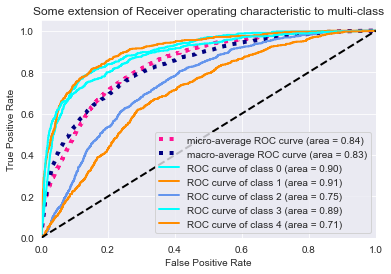

In [167]:
# First aggregate all false positive rates
# n_classes = len(set(labels_testing))
n_classes = 5
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [169]:
pd.get_dummies(list(set(training['Sentiment'].values)))

,Extremely Negative,Extremely Positive,Negative,Neutral,Positive
0,1,0,0,0,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,0,1,0,0
4,0,1,0,0,0


# Conclusion:
Micro averaged ROC: 0.84 \
Class 0, Class 1, Class 3 have a high ROC score of 0.9, 0.91, 0.89 (Extremely Negative, Extremely Positive, Neutral)

### Experimenting with moving the decision threshold

c:\users\avish\.conda\envs\phase3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


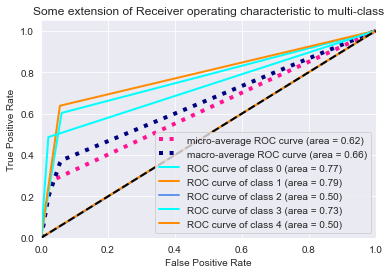

In [178]:
decision_dummies = np.where(decisions >0.55,1,0)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(labels_testing[:, i], decision_dummies[:, i]) # decision
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(labels_testing.ravel(), decision_dummies.ravel()) # decision
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
# n_classes = len(set(labels_testing))
n_classes = 5
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### Conclusion:

Not much improvement on moving the decision threshold.

Using probabilities to calculate